In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
n_den = 2.3e14
# G = c = 1

In [4]:
# Working in manual cgs units here. 

# DIMENSIONS CHECKED
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

# DIMENSIONS CHECKED
def _dPhidr(r, P, M):
    factor1 = G/(c**2) 
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return factor1*num/dem

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):
    factor2 = -1 # factor goes in dphi/dr
    term1 = (e+P) 
    dphidr = _dPhidr(r, P, M)
    return factor2 * term1 * dphidr

# DIMENSIONS CHECKED
def _dWdr(r, V, W, phi, dphidr, dedp, omega, lamda, l):
    term1 = (omega**2) * (r**2) * np.exp(lamda - 2*phi)*V * (1/(c**2))
    term2 = dphidr * W
    brackets = term1 + term2
    ret = dedp * brackets - l*(l+1)*np.exp(lamda)*V
    return ret

# DIMENSIONS CHECKED
def _dVdr(r, V, W, dphidr, lamda):
    return 2*dphidr*V - np.exp(lamda)*(W/(r**2))

def coupledTOV(r, VEC, init_params):
    P, M, phi, W, V = VEC
    f_e_smooth, l, omega, lamda = init_params
    
    e = f_e_smooth(P)
    dedp = 1. # THIS IS INCORRECT
    
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    dPhidr = _dPhidr(r, P, M)
    dWdr = _dWdr(r, V, W, phi, dPhidr, dedp, omega, lamda, l)
    dVdr = _dVdr(r, W, W, dPhidr, lamda)
    ret = [dPdr, dMdr, dPhidr, dWdr, dVdr]
    return ret

In [5]:
def df_to_ep(df):
    n_den = 2.3e14
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*(c**2)
    pressure = p*(c**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value="extrapolate")
    return f_e_smooth

In [6]:
def tov(ep, init_VEC, r_i, p_min, omega, lamda, progress = False, 
        l=2):
    
    init_params = [ep, l, omega, lamda]

    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 20 * km2cm
    # max_iter = 1000000 # Change back to this if "Excess work done on this call" error. 
    max_iter = 5000

    dr_init = r_max/max_iter
    dr_compute = 1000
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] >= p_min):
        i+=1

        dr = min(dr_init, dr_compute)

        integral = r.integrate(r.t+dr)
        
        results.append(integral)
        r_list.append(r.t+dr_init)

    #     dr_compute = r * dP /P 

        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
    
    if progress:
        pbar.close()
        
#     print(r.successful() , (r.y[0] > p_min))
    
    results = np.array(results, dtype = float)
    p, m, phi, w, v = results.T
    r = np.array(r_list)
    return p, m, r, phi, w, v

In [7]:
# Load EOS
df = pd.read_csv("eos_data/sly230a.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1e1 
p0 = p[-7]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = e0
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3

phi0 = -1 #Arbitrary guess 
omega = 1e3 #Arbitrary guess

C = 1 # Arbitrary constant
l = 2
W0 =  C   * r_i ** (l+1)
V0 = -C/l * r_i ** (l)

init_VEC = [p_c, m0, phi0, W0, V0]
msun = 2e33
p_min = min(p)

M_guess = 1.5 * msun
R_guess = 10 * km2cm
lamda = 0.5*np.log((1-2*G*M_guess/(c**2*R_guess)))

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, lamda, 
                       progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

# Log base e
phi_ext = 0.5 * np.log(schild) #At surface
phi_int = phi[-1] #At surface


# DIMENSIONED CHECKED
def boundary_wv(r_R, p_R, m_R, omega, lamda, phi_int, v_R):
    dPhidr_R = _dPhidr(r_R, p_R, m_R)
    term1 = (1/(c**2))*(omega**2 * r_R**2)*np.exp(lamda-2*phi_int)*v_R
    term2 = dPhidr_R * w_R
    return term1 + term2


print("== First Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 1: {phi0}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, lamda, phi_int, v_R)}")

# Computer new phi0
delta_phi = phi_int - phi_ext
phi0 =  phi0 - delta_phi

# Repeated Integration
C = 1 # Arbitrary constant

W0 =  C   * r_i ** (l+1)
V0 = -C/l * r_i ** (l)

init_VEC = [p_c, m0, phi0, W0, V0]
msun = 2e33
p_min = min(p)
M_guess = m_R
R_guess = r_R
lamda = 0.5*np.log((1-2*G*M_guess/(c**2*R_guess)))
time.sleep(0.2)

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, lamda, 
                       progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

print("== Repeated Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 2: {phi0}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, lamda, phi_int, v_R)}")

 50%|████▉     | 2487/5000 [00:03<00:04, 570.32it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
 51%|█████     | 2526/5000 [00:04<00:04, 605.05it/s]


== First Integration == 
Star has mass 2.1 Msun and radius 10.1km
Interior Surface: 0.6881
Exterior Surface: 0.3871
Phi0 Round 1: -1
Boundary Term: -9.479088880882955


 51%|█████     | 2526/5000 [00:03<00:03, 662.97it/s]

== Repeated Integration == 
Star has mass 2.1 Msun and radius 10.1km
Interior Surface: 0.3871
Exterior Surface: 0.3871
Phi0 Round 2: -1.2875879550918277
Boundary Term: 226.86575168994182


Boundary term changes since $\Phi_{int}(R)$ changes. 

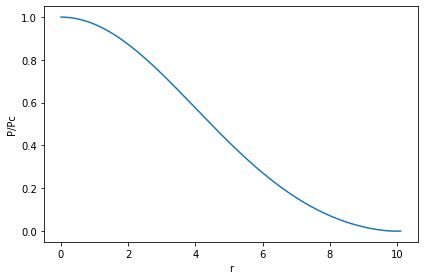

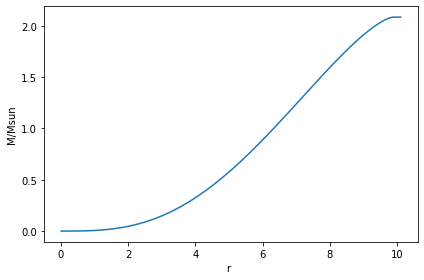

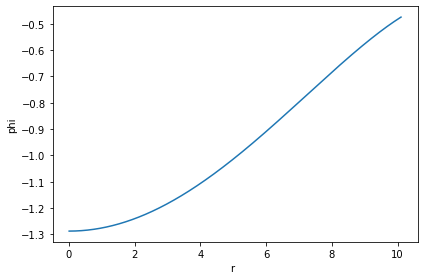

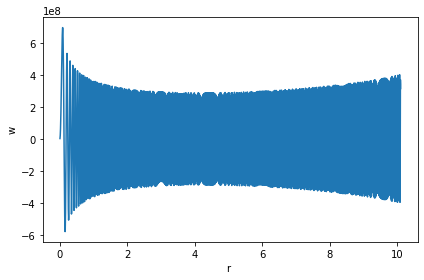

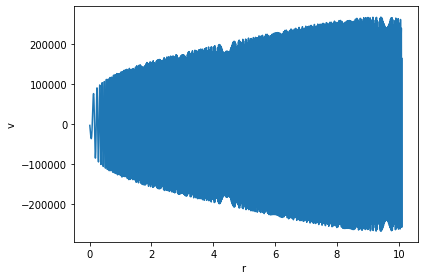

In [8]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

In [ ]:
def minimize_boundary(omega, p = p, EOS = EOS):
    # Repeat integration
    C = 1 # Arbitrary constant

    W0 =  C   * r_i ** (l+1)
    V0 = -C/l * r_i ** (l)

    init_VEC = [p_c, m0, phi0, W0, V0]
    msun = 2e33
    p_min = min(p)
    M_guess = m_R
    R_guess = r_R
    lamda = 0.5*np.log((1-2*G*M_guess/(c**2*R_guess)))
    time.sleep(0.2)

    # Integrate
    p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, lamda, 
                           progress = False, l = l)

    loss = abs(boundary_wv(r_R, p_R, m_R, omega, lamda, phi_int, v_R))
    print(loss)
    return loss

omega0 = 1e3
res = minimize(minimize_boundary, x0 = 1e3, method = "Nelder-Mead", 
               options = {"disp": True}, tol = 1e-1, bounds = (0, 1e4))

[226.86616349]
[103.83321255]
[25.20134575]


In [ ]:
# Final Integration
omega = res.x[0]
C = 1 # Arbitrary constant

W0 =  C   * r_i ** (l+1)
V0 = -C/l * r_i ** (l)

init_VEC = [p_c, m0, phi0, W0, V0]
msun = 2e33
p_min = min(p)
M_guess = m_R
R_guess = r_R
lamda = 0.5*np.log((1-2*G*M_guess/(c**2*R_guess)))
time.sleep(0.2)

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, lamda, 
                       progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

print("== Final Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 2: {phi0}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, lamda, phi_int, v_R)}")

In [ ]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()